YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed
/tmp/ipykernel_4880/3780330035.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_dates = momentum.resample('M').last().index
/tmp/ipykernel_4880/3780330035.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  signals = pd.DataFrame(index=returns.index, columns=returns.columns).fillna(0)


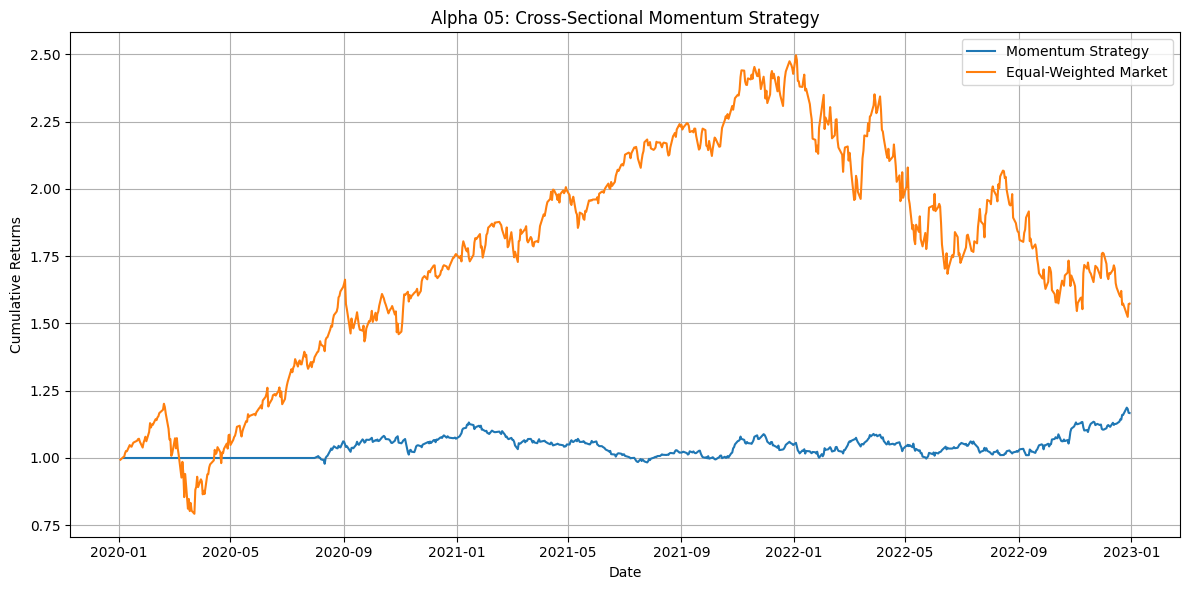

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Settings ===
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "TSLA", "NVDA", "JPM", "V", "MA"]
start_date = "2020-01-01"
end_date = "2023-01-01"

# === Download data ===
data = yf.download(tickers, start=start_date, end=end_date)['Close']
returns = data.pct_change().dropna()

# === Calculate 6-month momentum (past 126 trading days) ===
momentum = data.pct_change(126)

# === Monthly rebalancing dates ===
rebalance_dates = momentum.resample('M').last().index

# === Initialize signals ===
signals = pd.DataFrame(index=returns.index, columns=returns.columns).fillna(0)

for date in rebalance_dates:
    if date not in momentum.index:
        continue
    ranked = momentum.loc[date].dropna().sort_values(ascending=False)
    top = ranked.head(3).index
    bottom = ranked.tail(3).index
    signals.loc[date:, top] = 1
    signals.loc[date:, bottom] = -1

# === Backtest ===
strategy_returns = (signals.shift(1) * returns).mean(axis=1)
cumulative_strategy = (1 + strategy_returns).cumprod()
cumulative_market = (1 + returns.mean(axis=1)).cumprod()

# === Plot ===
plt.figure(figsize=(12, 6))
plt.plot(cumulative_strategy, label='Momentum Strategy')
plt.plot(cumulative_market, label='Equal-Weighted Market')
plt.title('Alpha 05: Cross-Sectional Momentum Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
